# Scarlet Function

Output function:
    
    for every band, output 1 fits file (name of input file, append _scarlet.fits at end)
    ... 3 fits files per 3 bands
    
    in each fits file:
        -have image itself (first header)
        - n headers for every n source detected in code
        - in every header will have an image of a model of that source and only that source
               this model will NOT be same size of full image. it'll be small cutout 
               thus for header of file imagename for those small cutouts need to put entry called bbox (4 vector) w/ X, Y, WIDTH, HEIGHT  ... tells you where cutout is in image
               
        - Set entry name (categoryID) to 1 for all (b/c all galaxies)
        
        
        From Fits files Colin can generate exact data structure for detectron.

WIll also have to create train, validation, and test set (split up images combos)

Run on train and validation but NOT test set.

In [1]:
%config InlineBackend.figure_format = 'retina' #for MacOS, make plots crisp

# Import necessary packages and setup
import os
import numpy as np
import scarlet
import sep 
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

from astropy.modeling.models import Ellipse2D
from astropy.coordinates import Angle
from regions import PixCoord, EllipsePixelRegion

import math

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

# Code adapted from the following scarlet tutorials:
# https://pmelchior.github.io/scarlet/tutorials/wavelet_model.html
# https://pmelchior.github.io/scarlet/tutorials/multiresolution.html


# Make source catalog. Mostly copied from https://pmelchior.github.io/scarlet/tutorials/wavelet_model.html
def makeCatalog(datas, lvl=4, wave=True, subtract_background=False):
    ''' Creates a detection catalog by combining low and high resolution data
    Parameters
    ----------
    datas: array
        array of Data objects
    lvl: int
        detection lvl
    wave: Bool
        set to True to use wavelet decomposition of images before combination
    subtract_background : Bool
        if you want to subtract the background and retrieve an estimate, change to True. But default 
        is False because HSC images are already background subtracted.
    
    Returns
    -------
    catalog: sextractor catalog
        catalog of detected sources
    bg_rms: array
        background level for each data set
    '''
    if type(datas) is np.ndarray:
        hr_images = datas / np.sum(datas, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(hr_images, axis=0)
    else:
        data_lr, data_hr = datas
        # Create observations for each image
        # Interpolate low resolution to high resolution
        interp = interpolate(data_lr, data_hr)
        # Normalisation of the interpolate low res images
        interp = interp / np.sum(interp, axis=(1, 2))[:, None, None]
        # Normalisation of the high res data
        hr_images = data_hr.images / np.sum(data_hr.images, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(interp, axis=0) + np.sum(hr_images, axis=0)
        detect_image *= np.sum(data_hr.images)
    if np.size(detect_image.shape) == 4:
        if wave:
            # Wavelet detection in the first three levels
            wave_detect = Starlet(detect_image.mean(axis=0), lvl=5).coefficients
            wave_detect[:, -1, :, :] = 0
            detect = scarlet.Starlet(coefficients=wave_detect).image
        else:
            # Direct detection
            detect = detect_image.mean(axis=0)
    else:
        if wave:
            wave_detect = scarlet.Starlet(detect_image).coefficients
            detect = wave_detect[0][0] + wave_detect[0][1] + wave_detect[0][2]
        else:
            detect = detect_image
    
    bkg = sep.Background(detect)
    # Set the limit on the number of sub-objects when deblending. Default is 1024
    sep.set_sub_object_limit(100000)
    print(len(detect))
    # Extract detection catalog with segmentation maps!
    # Can use this to retrieve ellipse params
    catalog = sep.extract(detect, lvl, err=bkg.globalrms,) #segmentation_map=True) #maskthresh=5.0)
            
    # If images are NOT YET background subtracted, find the background:        
    if subtract_background == True:
        if type(datas) is np.ndarray:
            bg_rms = scarlet.wavelet.mad_wavelet(datas)

        else:
            bg_rms = []
            for data in datas:
                bg_rms.append(scarlet.wavelet.mad_wavelet(data.images))

        return catalog, bg_rms
        
    # If images are already background subtracted (which they are), just return catalog 
    # because background will be 0, and you will be dividing by 0 which throws error
    if subtract_background == False:
        return catalog

    
    
#####################
def plot_image_cubes(
                filters=['G', 'R', 'I'],
                tract=10054,
                patch1=0,
                patch2=0,
                centerposY=2500,
                centerposX=1000,
                sizecutY=500,
                sizecutX=500,
                stretch_arr = [0.01, 0.1, 0.5, 1],
                Q_arr = [1, 10, 5, 100],
                plot_image_cubes=True,
                plot_image=True,
):
    """
    Plots different normalizations of your image using the stretch, Q parameters. 
    
    Parameters
    ----------
    filters : list 
        A list of filters for your images. E.g. ['G', 'R', 'I']. Must be uppercase to match the 
        default filename of the HSC images.
    tract : int
        An integer used for specifying the tract. E.g. 10054
    patch1 : int
        Patch #,# is broken up into two components. This is the first. E.g. 0
    patch2 : int
        Patch #,# is broken up into two components. This is the second. E.g. 0. Together, 
        patch 1 and patch 2 make i.e. 0,0
    centerposY : int
        Sets the center Y position argument on the ORIGINAL IMAGE for Cutout2D (center of image).
    centerposX : int
        Sets the center X position argument on the ORIGINAL IMAGE for Cutout2D (center of image).
    sizecutY : int
        Sets length of as 0 - sizecutY for height on the CUTOUT IMAGE.
    sizecutX : int
        Sets length of as 0 - sizecutY for height on the CUTOUT IMAGE.
    stretch_arr : array
        List of stretch params you want to permutate through to find optimal image normalization.
        Default is [0.01, 0.1, 0.5, 1]
    Q_arr : array
        List of Q params you want to permutate through to find optimal image normalization.
        Default is [1, 10, 5, 100]
    plot_image_cubes : boolean
        Tests of Q, stretch params to find optimal normalization for images. If True, plot combinations,
        if False, don't plot combinations. Default is True
    plot_image : boolean
        Plot image cube. Uses stretch=1, Q=5. Default is True
    """
    # The image filepath is in the form:
    # deepCoadd/HSC-{channel}/{tract}/{patch1},{patch2}/calexp-HSC-{channel}-{tract}-{patch1},{patch2}.fits.gz
    
    path = '/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/'
    dirpath = os.path.dirname(path)
    
    n = []

    for channel in filters:
        obs_hdul = fits.open(f'{dirpath}/HSC-{channel}/{tract}/{patch1},{patch2}/calexp-HSC-{channel}-{tract}-{patch1},{patch2}.fits.gz')
        data_hdu = obs_hdul[1].data
        wcs_hdu = WCS(obs_hdul[1].header)

        data_cut = Cutout2D(data_hdu, position=[centerposY, centerposX], size=[sizecutY,sizecutX], wcs=wcs_hdu) #image size is 4k x 4k
        n.append(data_cut.data)


    n = np.array(n)    
    obs_hdu = fits.PrimaryHDU(n)
    
    
    # Display image cube for finding good Q, stretch params
    if plot_image_cubes == True:
        fig, ax = plt.subplots(4,4, figsize=(9,12))
        for i, stretch in enumerate(stretch_arr):
            for j, Q in enumerate(Q_arr):
                asinh = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
                # Scale the RGB channels for the image
                img_rgb = scarlet.display.img_to_rgb(n, norm=asinh)
                ax[i][j].imshow(img_rgb)
                ax[i][j].set_title("Stretch {}, Q {}".format(stretch, Q))
                ax[i][j].axis('off')
                
    
    # Display one image cube
    stretch = 1
    Q = 5
    norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
    img_rgb = scarlet.display.img_to_rgb(n, norm=norm)
    
#####
    if plot_image == True:
        plt.figure(figsize = (8,8))
        plt.imshow(img_rgb)
        plt.title("Stretch {}, Q {}".format(stretch, Q))
        plt.show()
    
    

    
    
################################
# Run scarlet implementation
# TODO: include an option in function to use Cutout2D from ra,dec !!!!
# TODO: Run on 4K image but break it up in code and stitch it back together 
def run_scarlet(filters=['G', 'R', 'I'],
                tract=10055,
                patch1=1,
                patch2=0,
                centerposY=2500,
                centerposX=1000,
                sizecutY=500,
                sizecutX=500,
                subtract_background=False,
                plot_wavelet_transform=False,
                plot_detections=True,
                plot_ellipse=False,
                plot_likelihood=True,
                plot_full_scene=False,
                plot_all_sources=False,
                plot_first_isolated_comp=False,
               ):
    
    """ Run P. Melchior's scarlet (https://github.com/pmelchior/scarlet) implementation 
    for source separation. This function will create diagnostic plots, a source detection catalog, 
    and fit a model for all sources in the observation scene (image).

    Parameters
    ----------
    filters : list 
        A list of filters for your images. E.g. ['G', 'R', 'I']. Must be uppercase to match the 
        default filename of the HSC images.
    tract : int
        An integer used for specifying the tract. E.g. 10054
    patch1 : int
        Patch #,# is broken up into two components. This is the first. E.g. 0
    patch2 : int
        Patch #,# is broken up into two components. This is the second. E.g. 0. Together, 
        patch 1 and patch 2 make i.e. 0,0
    centerposY : int
        Sets the center Y position argument on the ORIGINAL IMAGE for Cutout2D (center of image).
    centerposX : int
        Sets the center X position argument on the ORIGINAL IMAGE for Cutout2D (center of image).
    sizecutY : int
        Sets length of as 0 - sizecutY for height on the CUTOUT IMAGE.
    sizecutX : int
        Sets length of as 0 - sizecutY for height on the CUTOUT IMAGE.
    subtract_background : boolean
        if you want to subtract the background and retrieve an estimage, change to True. Ensure this
        is the same value as in makeCatalog() function. Because HSC images are already background 
        subtracted, default value is False
    plot_wavelet_transform : boolean
        Plot starlet wavelet transform and inverse transform at different scales. 
        NOTE: Not really useful at large image sizes (> ~few hundred pixels length/height)
        Default is False
    plot_detections : boolean
        Plot detection catalog results. Default is False
    plot_ellipse : boolean
        Overplot the ellipse fits of detections from sep.extract. Default is False. 
    plot_likelihood : boolean
        Plot likelihood as function of iterations from Blend fit function. Default is True
    plot_full_scene : boolean
        Plot full scene with the model, rendered model, observation, and residual. Default is False.
    plot_all_sources : boolean
        Plot the model, rendered model, observation, and spectrum across channels for each object. 
        WARNING: dumb to do this with a large image with many sources! Default is False
    plot_first_isolated_comp : boolean
        Plot the subtracted and isolated first (or any) starlet component. Recommended for finding a bright
        component. Default is False.


    Return
    -------
    .fits file with...
    TODO: fill this out once I get the exact fits file output generated to Colin's liking 
    """    
    
    # The image filepath is in the form:
    # deepCoadd/HSC-{channel}/{tract}/{patch1},{patch2}/calexp-HSC-{channel}-{tract}-{patch1},{patch2}.fits.gz
    
    path = '/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/'
    dirpath = os.path.dirname(path)
    
    n = []

    for channel in filters:
        obs_hdul = fits.open(f'{dirpath}/HSC-{channel}/{tract}/{patch1},{patch2}/calexp-HSC-{channel}-{tract}-{patch1},{patch2}.fits.gz')
        data_hdu = obs_hdul[1].data
        wcs_hdu = WCS(obs_hdul[1].header)

        data_cut = Cutout2D(data_hdu, position=[centerposY, centerposX], size=[sizecutY,sizecutX], wcs=wcs_hdu) #image size is 4k x 4k
        n.append(data_cut.data)


    n = np.array(n)    
    obs_hdu = fits.PrimaryHDU(n)

    
#####    
        
    # Display one image cube
    stretch = 1
    Q = 5
    norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
    img_rgb = scarlet.display.img_to_rgb(n, norm=norm)
    
    # Wavelet source catalog if background has yet to be subtracted
    if subtract_background == True:
        # Detection and background noise estimate
        catalog, bg_rms_hsc = makeCatalog(n, 3, 1)
        weights = np.ones_like(n) / (bg_rms_hsc**2)[:, None, None]
    
    # Wavelet source catalog if background is already subtracted (DEFAULT for HSC images!)
    if subtract_background == False:
        # Apply and retrieve wavelet source catalog.
        catalog = makeCatalog(n, 3, 1)
        weights = np.ones_like(n)
    
    print("Source catalog found ", len(catalog), "objects")
    
    
#####
    # Plot wavelet transform at different scales
    # NOTE: Not really useful at large image sizes (> ~few hundred pixels length/height)
    if plot_wavelet_transform == True:
        #Declare a starlet object (and performs the transform)
        Sw = scarlet.Starlet(n, lvl = 5, direct = True)
        #This is the starlet transform as an array
        w = Sw.coefficients
        #The inverse starlet transform of w (new object otherwise, the tranform is not used)
        iw = Sw.image

        #The wavelet transform of the first slice of images in pictures:
        lvl = w.shape[1]
        plt.figure(figsize = (lvl*5+5,5))
        plt.suptitle('Wavelet coefficients')
        for i in range(lvl):
            plt.subplot(1,lvl,i+1)
            plt.title('scale'+str(i+1))
            plt.imshow(w[0,i], cmap='inferno')
            plt.colorbar()
        plt.show()

        #Making sure we recover the original image:
        plt.figure(figsize = (30,10))
        plt.subplot(131)
        plt.title('Original image', fontsize = 20)
        plt.imshow(n[0], cmap='inferno')
        plt.colorbar()
        plt.subplot(132)
        plt.title('Starlet-reconstructed image', fontsize = 20)
        plt.imshow(iw[0], cmap='inferno')
        plt.colorbar()
        plt.subplot(133)
        plt.title('Absolute difference', fontsize = 20)
        plt.imshow((np.abs(iw[0]-n[0])), cmap='inferno')
        plt.colorbar()
        plt.show()
        
    # Define model frame and observations:
    # Model
    model_psf = scarlet.GaussianPSF(sigma = 0.9, boxsize=100) # Large boxsize (pix) to account for large sources

    model_frame = scarlet.Frame(
        n.shape,
        psf=model_psf,
        channels=filters)

    # HSC observation frame from data

    #would be replaced by data psf it we had one :( )
    #also make slightly different from model_psf
    observation_psf = scarlet.GaussianPSF(sigma = 0.8) 

    observation = scarlet.Observation(
        n,
        psf=observation_psf, 
        weights=weights,
        channels=filters).match(model_frame)
    
    
##### 
    # Plot detections on image cube to verify
    print(f"Plotting {len(catalog)} detections from catalog onto the image cube...")
    if plot_detections == True:

        fig, ax = plt.subplots(figsize = (20,20))
        # Mark all of the sources from the detection catalog
        for k, src in enumerate(catalog):
            
            if plot_ellipse == True: # FROM WAVELET DETECTIONS, NOT MODEL!
                # Overplot ellipses onto detections!
                a, b, theta = src["a"], src["b"], np.rad2deg(src["theta"]) # pix, pix, deg
                x0, y0 = src["x"], src["y"]
                center = PixCoord(x=x0, y=y0)
                theta_angle = Angle(theta, 'deg') # make Angle obj for EllipsePixelRegion
                
                reg = EllipsePixelRegion(center=center, width=6*a, height=6*b, angle=theta_angle)
                patch = reg.as_artist(facecolor='none', edgecolor='white', lw=2)
                ax.add_patch(patch)
            
            ax.text(src["x"], src["y"], str(k), color="green", fontsize = 25)
            ax.plot(src["x"], src["y"], 'bx', markersize = 15)
        ax.imshow(img_rgb)
        
          
    # Initialize starlet sources to be fit. Assume extended sources for all because 
    # we are not looking at all detections in each image
    
    # TODO: Plot chi2 vs. binned size and mag. Implement conidition if chi2 > xxx then
    # add another component until larger sources are modeled well.
    print("Initializing starlet sources to be fit...")
    starlet_sources = []
    for k,src in enumerate(catalog):
        #if k in [12,13,16]:
        #    new_source = scarlet.StarletSource(model_frame,
        #                    (src["x"], src["y"]), observation,
        #                    starlet_thresh = 1)
        #    starlet_sources.append(new_source)
        #else:
        new_source = scarlet.ExtendedSource(model_frame,
                                        (src['y'], src['x']),
                                        observation,
                                        K=1,
                                        compact = 1)
        starlet_sources.append(new_source)
        
    # Create and fit Blend model. Go for 200 iterations,
    # but will end early if likelihood and constraints converge.
    print(f"fitting Blend model...")
    try:
        starlet_blend = scarlet.Blend(starlet_sources, observation)
        it, logL = starlet_blend.fit(200, e_rel=1e-4)
        print(f"scarlet ran for {it} iterations to logL = {logL}")

        if plot_likelihood == True:
            scarlet.display.show_likelihood(starlet_blend)
            plt.show()
            
#####
        # Render the entire scene. 
        # Plot the model, observation, 𝑠𝑖𝑛ℎ−1 stretch and the residuals with a linear stretch.
        if plot_full_scene == True:
            scarlet.display.show_scene_w_ellipse(starlet_sources,
                           catalog=catalog,
                           norm=norm,
                           observation=observation,
                           show_rendered=False,
                           show_observed=True,
                           show_residual=True,
                          )
            
            plt.show()
            

#####
        # Plot to see EACH model individually for each source. 
        # HOWEVER, this is stupid for > 10 objects in the scene...    
        if plot_all_sources == True:
            scarlet.display.show_sources_w_ellipse(starlet_sources,
                                         catalog,
                                         norm=norm,
                                         observation=observation,
                                         show_rendered=True,
                                         show_observed=True,
                                         add_boxes=True
                                        )
            plt.show()

##### 
        # Subtract and isolate the first (or any) starlet component
        if plot_first_isolated_comp == True:
            lsbg = starlet_sources[0].get_model(frame=model_frame)
            model = 0
            for k in range(len(starlet_sources)):
                model += starlet_sources[k].get_model(frame=model_frame)
            lsbg = observation.render(lsbg)
            res_rgb = scarlet.display.img_to_rgb(n-lsbg, norm=norm)
            img_rgb = scarlet.display.img_to_rgb(n, norm=norm)
            lsbg_rgb = scarlet.display.img_to_rgb(lsbg, norm=norm)
            model_rgb = scarlet.display.img_to_rgb(n-model, norm=norm)

            plt.figure(figsize = (30,15))
            plt.subplot(131)
            plt.imshow(img_rgb)

            plt.subplot(133)
            plt.imshow(lsbg_rgb)

            plt.subplot(132)
            plt.imshow(res_rgb)
            plt.show()
            
            
            
            
            
            
            
        ##############################    
        # SAVE RESULTS!!!
        # Save full image
        save_hdu = fits.PrimaryHDU(data=img_rgb) # Primary HDU is full image
        header = save_hdu.header # each full image has a header with height, width of image
        header['HEIGHT'] = img_rgb.shape[0]
        header['WIDTH'] = img_rgb.shape[1]
        
        # Save each model source
        save_starlet_source_list = []
        
        for k in range(len(starlet_sources)):
            
            # Get each model, make into image
            my_starlet_source = starlet_sources[k].get_model(frame=model_frame)
            my_starlet_source = observation.render(my_starlet_source)
            starlet_source_img_rgb = scarlet.display.img_to_rgb(my_starlet_source, norm=norm)
            
            # Save model with location info (relative to full image file) in headers
            save_hdu_ss = fits.ImageHDU(data=starlet_source_img_rgb) #Ensure it's IMAGE HDU NOT PRIMARY
            save_hdr_ss = fits.Header()
            save_hdr_ss['CENTER_Y'] = starlet_sources[k].center[0]
            save_hdr_ss['CENTER_X'] = starlet_sources[k].center[1]
            save_hdr_ss['BBOX_STA'] = tuple(starlet_sources[k].bbox.start[1:3]) # ASK COLIN: CAN'T HAVE 3 tuple???
            save_hdr_ss['BBOX_STP'] = tuple(starlet_sources[k].bbox.stop[1:3])
            save_hdr_ss['ID'] = 1 # Category ID
            #print(tuple(starlet_sources[k].bbox.start[1:3]))
            #print(tuple(starlet_sources[k].bbox.stop[1:3]))
            save_starlet_source_list.append(save_hdu_ss)
        
        # Write final fits file to specified location
        #for channel in filters:
        #    save_hdul = fits.HDUList([save_hdu, save_starlet_source_list[0]])
        #    save_hdul.writeto(f'{dirpath}/HSC-{channel}/{tract}/{patch1},{patch2}/scarlet-HSC-{channel}-{tract}-{patch1},{patch2}_position={centerposY},{centerposX}_sizecut={sizecutY},{sizecutX}.fits') 
        
        
        
        # Catch any exceptions like no detections
    except AssertionError as e1:
        print(f"Length of detection catalog is {len(catalog)}. Skip and go to next image cutout!")

    
    


200
Source catalog found  12 objects
Plotting 12 detections from catalog onto the image cube...
Initializing starlet sources to be fit...
fitting Blend model...


/home/paleo2/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/ipykernel_launcher.py:91: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


scarlet ran for 54 iterations to logL = -74145.1104318004


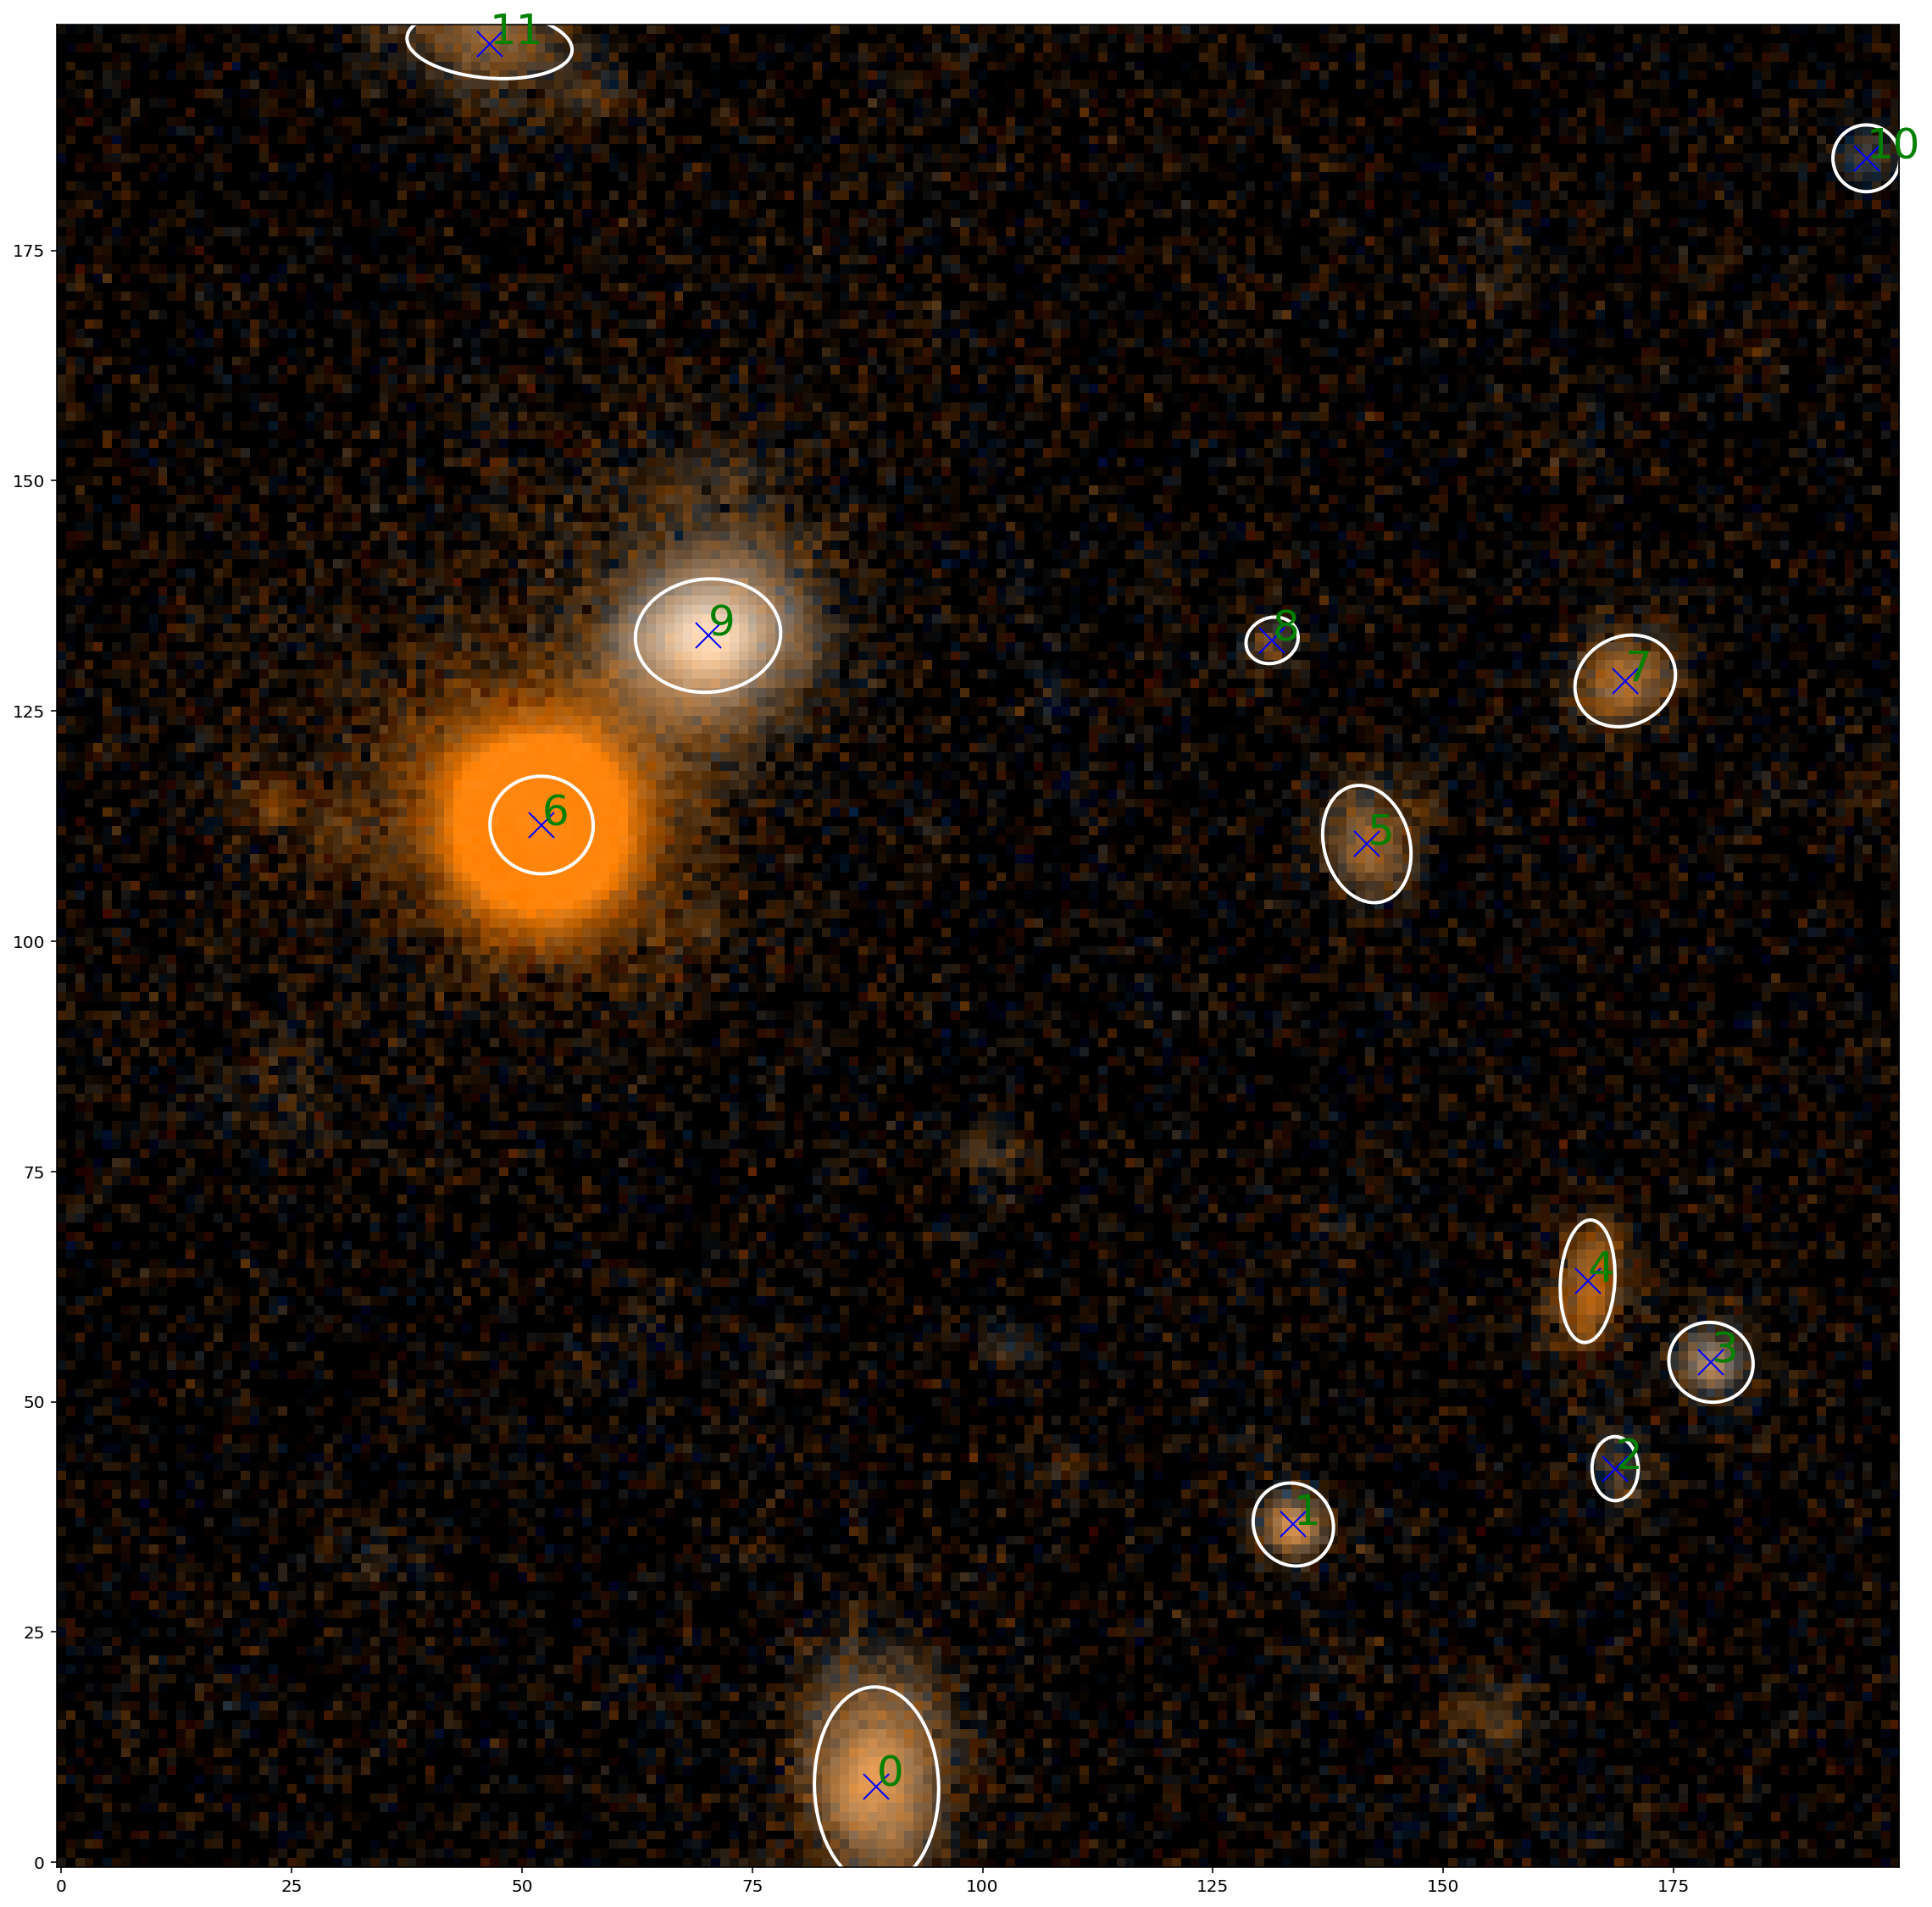

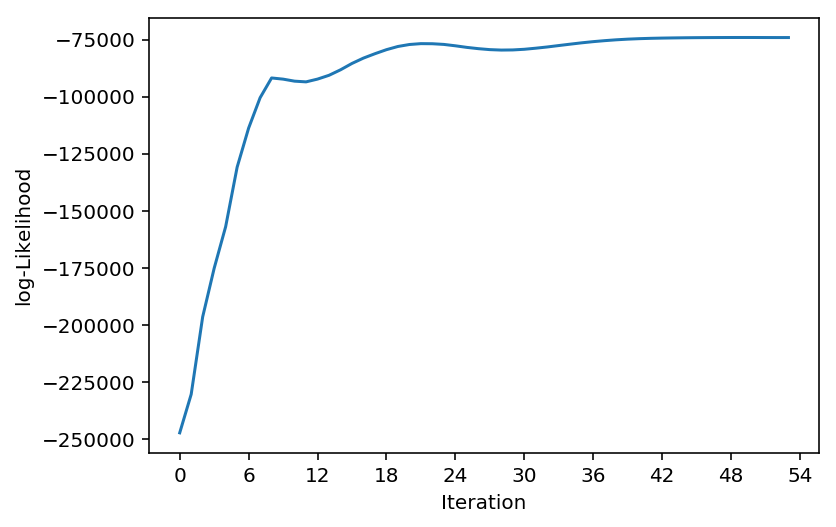

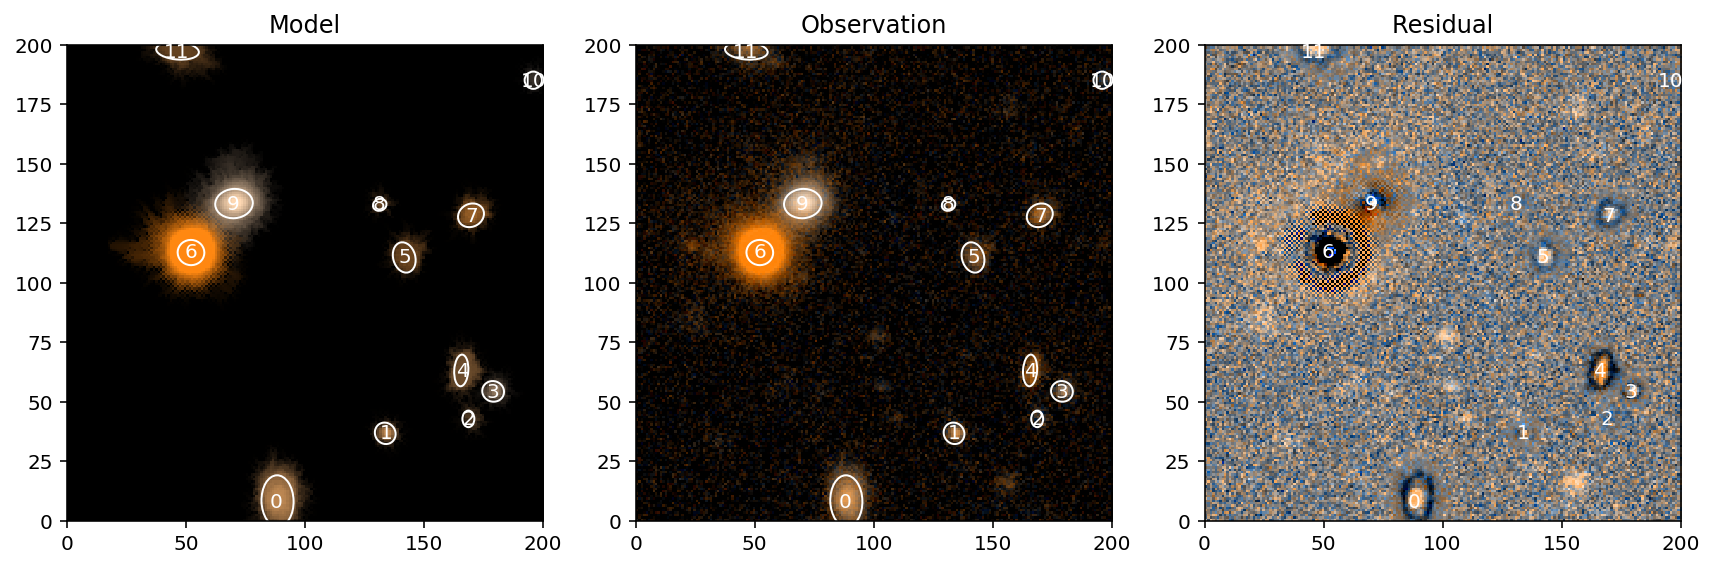

CPU times: user 13.4 s, sys: 83.5 ms, total: 13.4 s
Wall time: 11.8 s


In [2]:
%%time

# Image details
filters=['G', 'I']#, 'R', 'I'],
tract=9570
patch1=4
patch2=8
centerposY=2700
centerposX=2600
sizecutY=200
sizecutX=200

plot_image_cubes(filters=filters,
                        tract=tract,
                        patch1=patch1,
                        patch2=patch2,
                        centerposY=centerposY,
                        centerposX=centerposX,
                        sizecutY=sizecutY,
                        sizecutX=sizecutX,
                        stretch_arr = [0.01, 0.1, 0.5, 1],
                        Q_arr = [1, 10, 5, 100],
                        plot_image_cubes=True,
                        plot_image=True,
                       )


run_scarlet(filters=filters,
                        tract=tract,
                        patch1=patch1,
                        patch2=patch2,
                        centerposY=centerposY,
                        centerposX=centerposX,
                        sizecutY=sizecutY,
                        sizecutX=sizecutX,
                        subtract_background=False,
                        plot_wavelet_transform=False,
                        plot_detections=True,
                        plot_ellipse=True,
                        plot_likelihood=True,
                        plot_full_scene=True,
                        plot_all_sources=True,
                        plot_first_isolated_comp=False,
                       )

# ########OLD IGNORE############

# Starlet implementation of  HSC image

#### Starlets are a familly of functions that are generative of the ensemble of real matrices of finite sahpes and overcomplete. In that regard, shapelets have the flexibility to represent any pixelated 2-D profile. We take advantage of this property and use starlets to model sources with features that are too complex to be modeled with only assumptions of symmetry or monotonicity, such as irregular galaxies and spiral galaxies.

#### Following a mix of 
- https://pmelchior.github.io/scarlet/tutorials/wavelet_model.html
- https://pmelchior.github.io/scarlet/tutorials/multiresolution.html

In [1]:
%config InlineBackend.figure_format = 'retina' #for MacOS, make plots crisp

# Import Packages and setup
import numpy as np
import scarlet
import sep 
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

In [2]:
# Location of scarlet installation on paleo2's account

scarlet.__file__

'/home/paleo2/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/scarlet-1.0.1+gfde109a-py3.7-linux-ppc64le.egg/scarlet/__init__.py'

#### Check package versions, to ensure they are up to date

In [3]:
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

1.0.1+gfde109a
1.20.1
1.1.1


### Take separate HSC images in g,r,i bands, and combine into one usable multiband image 

#### Note: deepCoadd calexp deepCoadd/$(filter)/$(tract)/$(patch)/calexp-$(filter)-$(tract)-$(patch).fits

The format of hsc data folders are as follows:

_det_: List of source positions and footprints detected on a coadd patch. (FITS BINTABLE)

_warp_: Image of a single visit (CORR) transformed onto a destination tangential plane in a tract. (Multi-extension FITS IMAGE + BINTABLE)

_calexp_: Coadd image in a single band, or resultant image from the Stack stage, which combines all the overlapped warp images. (Multi-extension FITS IMAGE + BINTABLE)

In [16]:
channels_hsc = ['G', 'R', 'I']
n = []

for channel in channels_hsc:
    obs_hdul = fits.open(f'../../HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/HSC-{channel}/10054/0,0/calexp-HSC-{channel}-10054-0,0.fits.gz')
    data_hdu = obs_hdul[1].data
    wcs_hdu = WCS(obs_hdul[1].header)
    
    data_cut = Cutout2D(data_hdu, position=[0, 0], size=[2000,2000], wcs=wcs_hdu) #image size is 4k x 4k
    n.append(data_cut.data)
    #n.append(data_hdu)
    
n = np.array(n)    
obs_hdu = fits.PrimaryHDU(n)
#print(data_cut)

### Display Image Cube

#### Looking for good Stretch, Q combination:

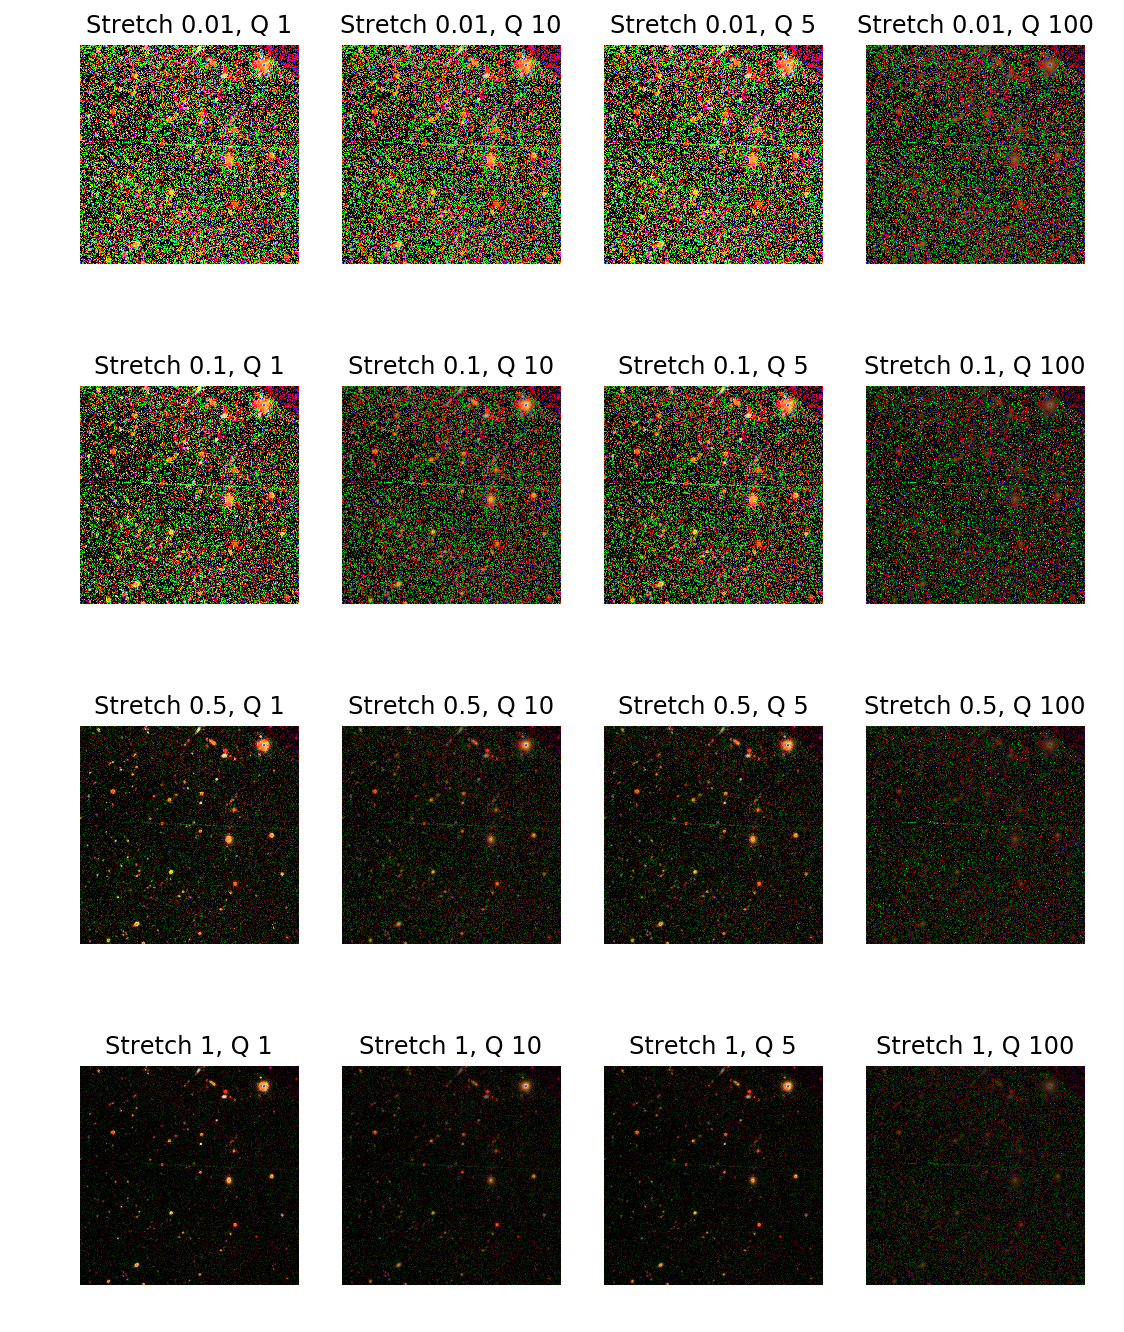

In [5]:
fig, ax = plt.subplots(4,4, figsize=(9,12))
for i, stretch in enumerate([0.01, 0.1, 0.5, 1]):
    for j, Q in enumerate([1, 10, 5, 100]):
        asinh = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
        # Scale the RGB channels for the image
        img_rgb = scarlet.display.img_to_rgb(n, norm=asinh)
        ax[i][j].imshow(img_rgb)
        ax[i][j].set_title("Stretch {}, Q {}".format(stretch, Q))
        ax[i][j].axis('off')

#### Stretch=1, Q=5 looks the best. Confirm by making plotting bigger figure

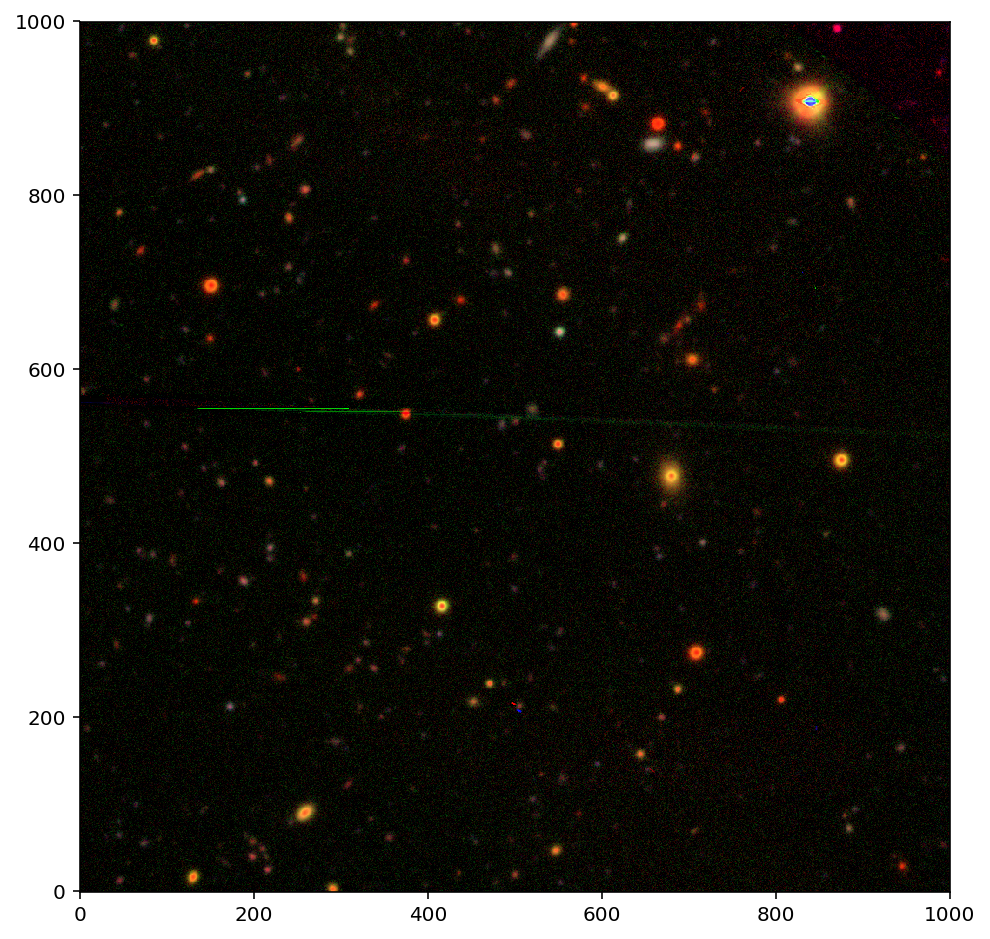

height, width, channels, = (1000, 1000, 3)


In [17]:
from scarlet.display import AsinhMapping

stretch = 1
Q = 5
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(n, norm=norm)
plt.figure(figsize = (8,8))
plt.imshow(img_rgb)
plt.show()

print('height, width, channels, =', img_rgb.shape) #height, width, channels

In [13]:
img_rgb

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0, 14,  3],
        ...,
        [ 0,  0,  8],
        [ 0,  0,  0],
        [ 7, 12,  0]],

       [[16,  0,  9],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [27,  0,  2],
        [ 7, 38, 10]],

       [[ 0,  6,  1],
        [ 0,  0,  0],
        [17,  4,  3],
        ...,
        [27, 23,  0],
        [19, 14,  4],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 1,  1, 12],
        [15,  1, 29],
        [83,  1, 27]],

       [[14,  0,  4],
        [23,  2, 10],
        [14,  4,  9],
        ...,
        [ 6,  1,  7],
        [42,  1, 14],
        [35,  1, 24]],

       [[14,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [22,  1, 40],
        [60,  1, 36],
        [ 7,  1, 12]]], dtype=uint8)

In [14]:
img_rgb.shape

(1000, 1000, 3)

In [15]:
len(img_rgb.flatten())

3000000

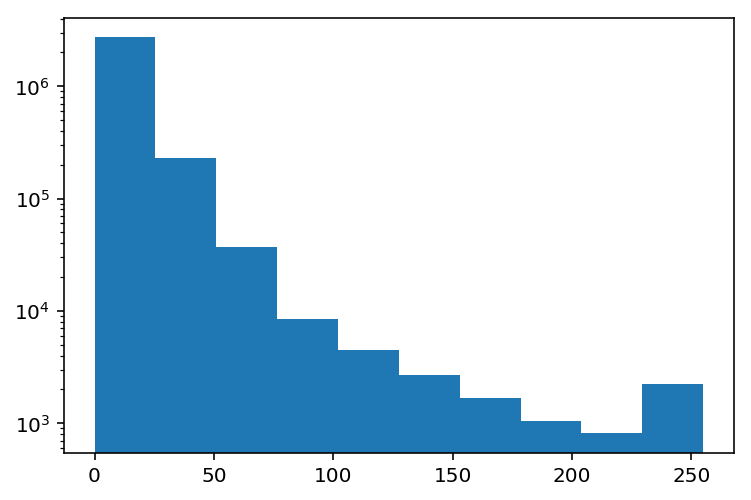

In [16]:
plt.hist(img_rgb.flatten())
plt.yscale('log')

In [17]:
g_med = np.median(img_rgb[:,:,0])
r_med = np.median(img_rgb[:,:,1])
i_med = np.median(img_rgb[:,:,2])

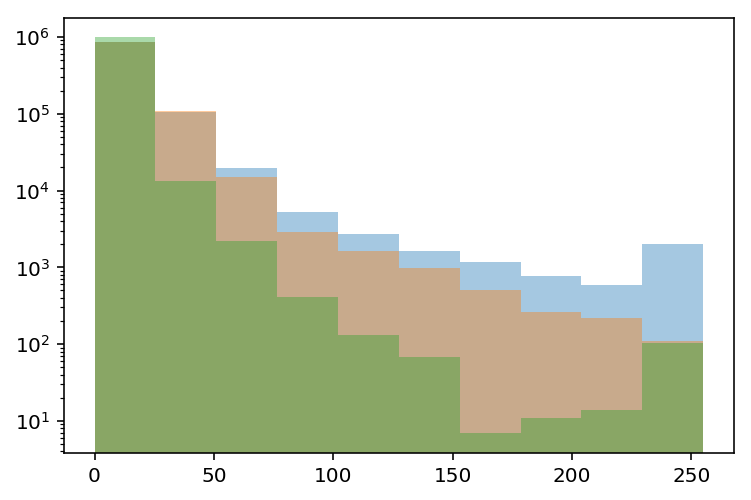

In [18]:
plt.hist(np.hstack(img_rgb[:,:,0]), alpha=0.4, label='g')
plt.hist(np.hstack(img_rgb[:,:,1]), alpha=0.4, label='r')
plt.hist(np.hstack(img_rgb[:,:,2]), alpha=0.4, label='i')
plt.yscale('log')

In [19]:
np.shape(img_rgb)

(1000, 1000, 3)

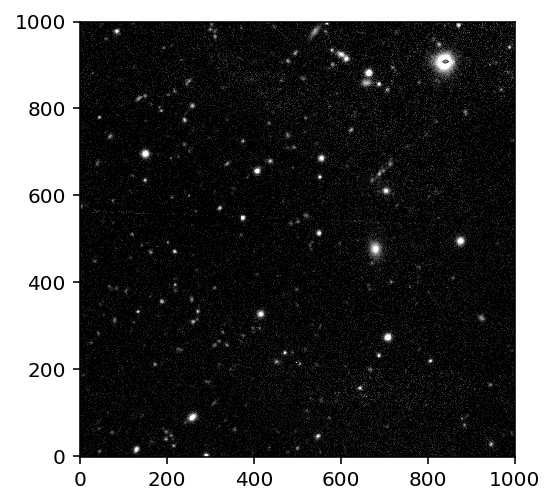

In [20]:
plt.imshow(img_rgb[:, :, 0])

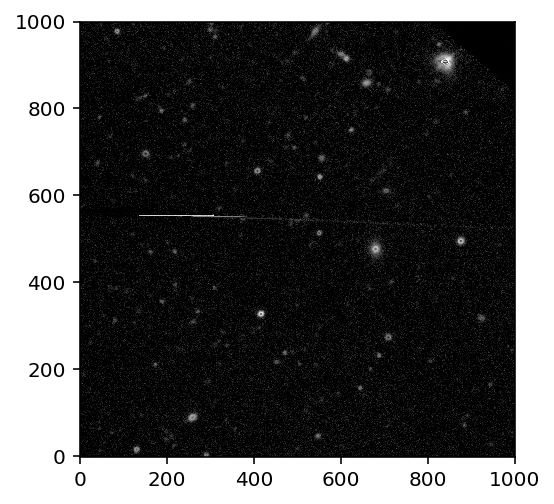

In [21]:
plt.imshow(img_rgb[:, :, 1])

In [22]:
img_rgb_masked = np.any(img_rgb > [0, 0, 0], axis=-1)


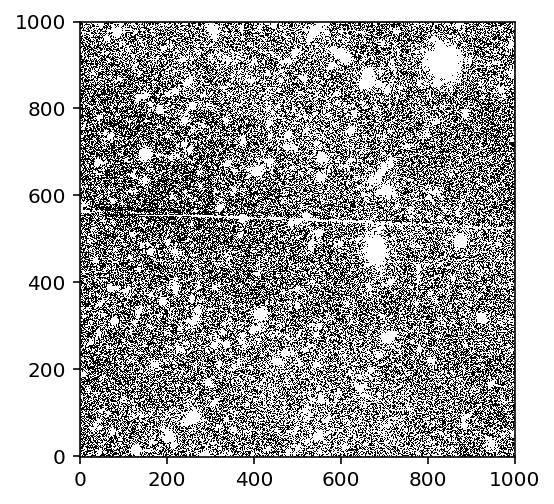

In [23]:
plt.imshow(img_rgb_masked)

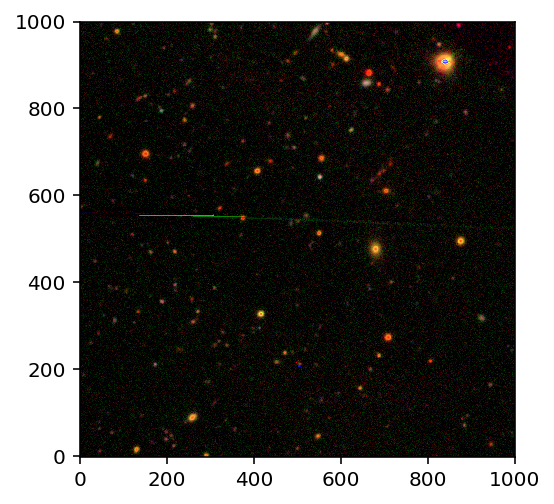

In [24]:
plt.imshow(img_rgb)

In [28]:
img_rgb[1400:1450, 1400:1450]

array([], shape=(0, 0, 3), dtype=uint8)

### This looks good.

### Build detection catalog to get centers, weights, etc. Because we don’t have a detection catalog, we need to build one. We’ll use a combination of wavelet filtering and SEP.

In [18]:
# To keep with scarlet naming convention:
images = n 
filters = channels_hsc
# weights = ... we will get weights with the next cell

In [33]:
def makeCatalog(datas, lvl=3, wave=True):
    ''' Creates a detection catalog by combining low and high resolution data
    Parameters
    ----------
    datas: array
        array of Data objects
    lvl: int
        detection lvl
    wave: Bool
        set to True to use wavelet decomposition of images before combination
    Returns
    -------
    catalog: sextractor catalog
        catalog of detected sources
    bg_rms: array
        background level for each data set
    '''
    if type(datas) is np.ndarray:
        hr_images = datas / np.sum(datas, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(hr_images, axis=0)
    else:
        data_lr, data_hr = datas
        # Create observations for each image
        # Interpolate low resolution to high resolution
        interp = interpolate(data_lr, data_hr)
        # Normalisation of the interpolate low res images
        interp = interp / np.sum(interp, axis=(1, 2))[:, None, None]
        # Normalisation of the high res data
        hr_images = data_hr.images / np.sum(data_hr.images, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(interp, axis=0) + np.sum(hr_images, axis=0)
        detect_image *= np.sum(data_hr.images)
    if np.size(detect_image.shape) == 3:
        if wave:
            # Wavelet detection in the first three levels
            wave_detect = Starlet(detect_image.mean(axis=0), lvl=4).coefficients
            wave_detect[:, -1, :, :] = 0
            detect = scarlet.Starlet(coefficients=wave_detect).image
        else:
            # Direct detection
            detect = detect_image.mean(axis=0)
    else:
        if wave:
            wave_detect = scarlet.Starlet(detect_image).coefficients
            detect = wave_detect[0][0] + wave_detect[0][1] + wave_detect[0][2]
        else:
            detect = detect_image
    
    bkg = sep.Background(detect)

    catalog = sep.extract(detect, lvl, err=bkg.globalrms)

    return catalog

catalog = makeCatalog(images, 3, 1)
#print(images)
weights = np.ones_like(images)

"""
    bkg = sep.Background(detect)

    catalog = sep.extract(detect, lvl, err=bkg.globalrms)

    if type(datas) is np.ndarray:
        bg_rms = scarlet.wavelet.mad_wavelet(datas)

    else:
        bg_rms = []
        for data in datas:
            bg_rms.append(scarlet.wavelet.mad_wavelet(data.images))

    return catalog, bg_rms

# Detection and background noise estimate
catalog, bg_rms_hsc = makeCatalog(images, 3, 1)
weights = np.ones_like(images) / (bg_rms_hsc**2)[:, None, None]
"""

/home/paleo2/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


'\n    bkg = sep.Background(detect)\n\n    catalog = sep.extract(detect, lvl, err=bkg.globalrms)\n\n    if type(datas) is np.ndarray:\n        bg_rms = scarlet.wavelet.mad_wavelet(datas)\n\n    else:\n        bg_rms = []\n        for data in datas:\n            bg_rms.append(scarlet.wavelet.mad_wavelet(data.images))\n\n    return catalog, bg_rms\n\n# Detection and background noise estimate\ncatalog, bg_rms_hsc = makeCatalog(images, 3, 1)\nweights = np.ones_like(images) / (bg_rms_hsc**2)[:, None, None]\n'

# IN FUNC. ADD BACKGROUND SUBRTRACTION, SET TO FALSE AND DELETE RELEVANT CODE BUT KEEP FOR NON_BACKGROUND SUBTRACTED DATA

### This shows how the wavelet transform and inverse transform works in scarlet. As a check we make sure that the transform and its inverse lead to the original image.

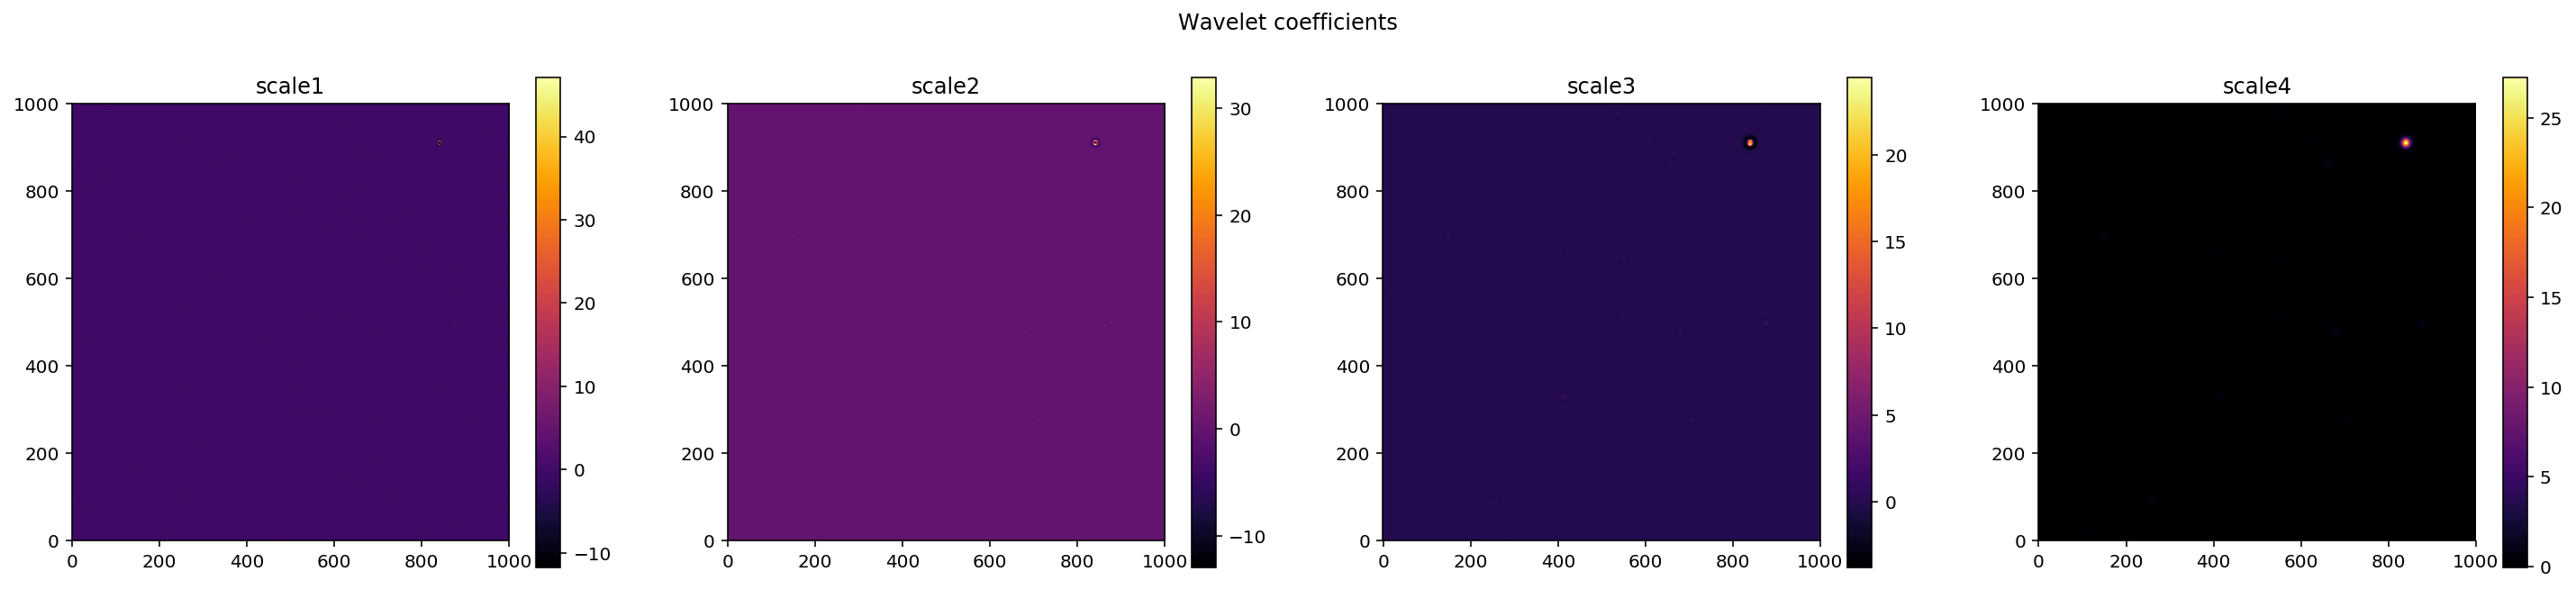

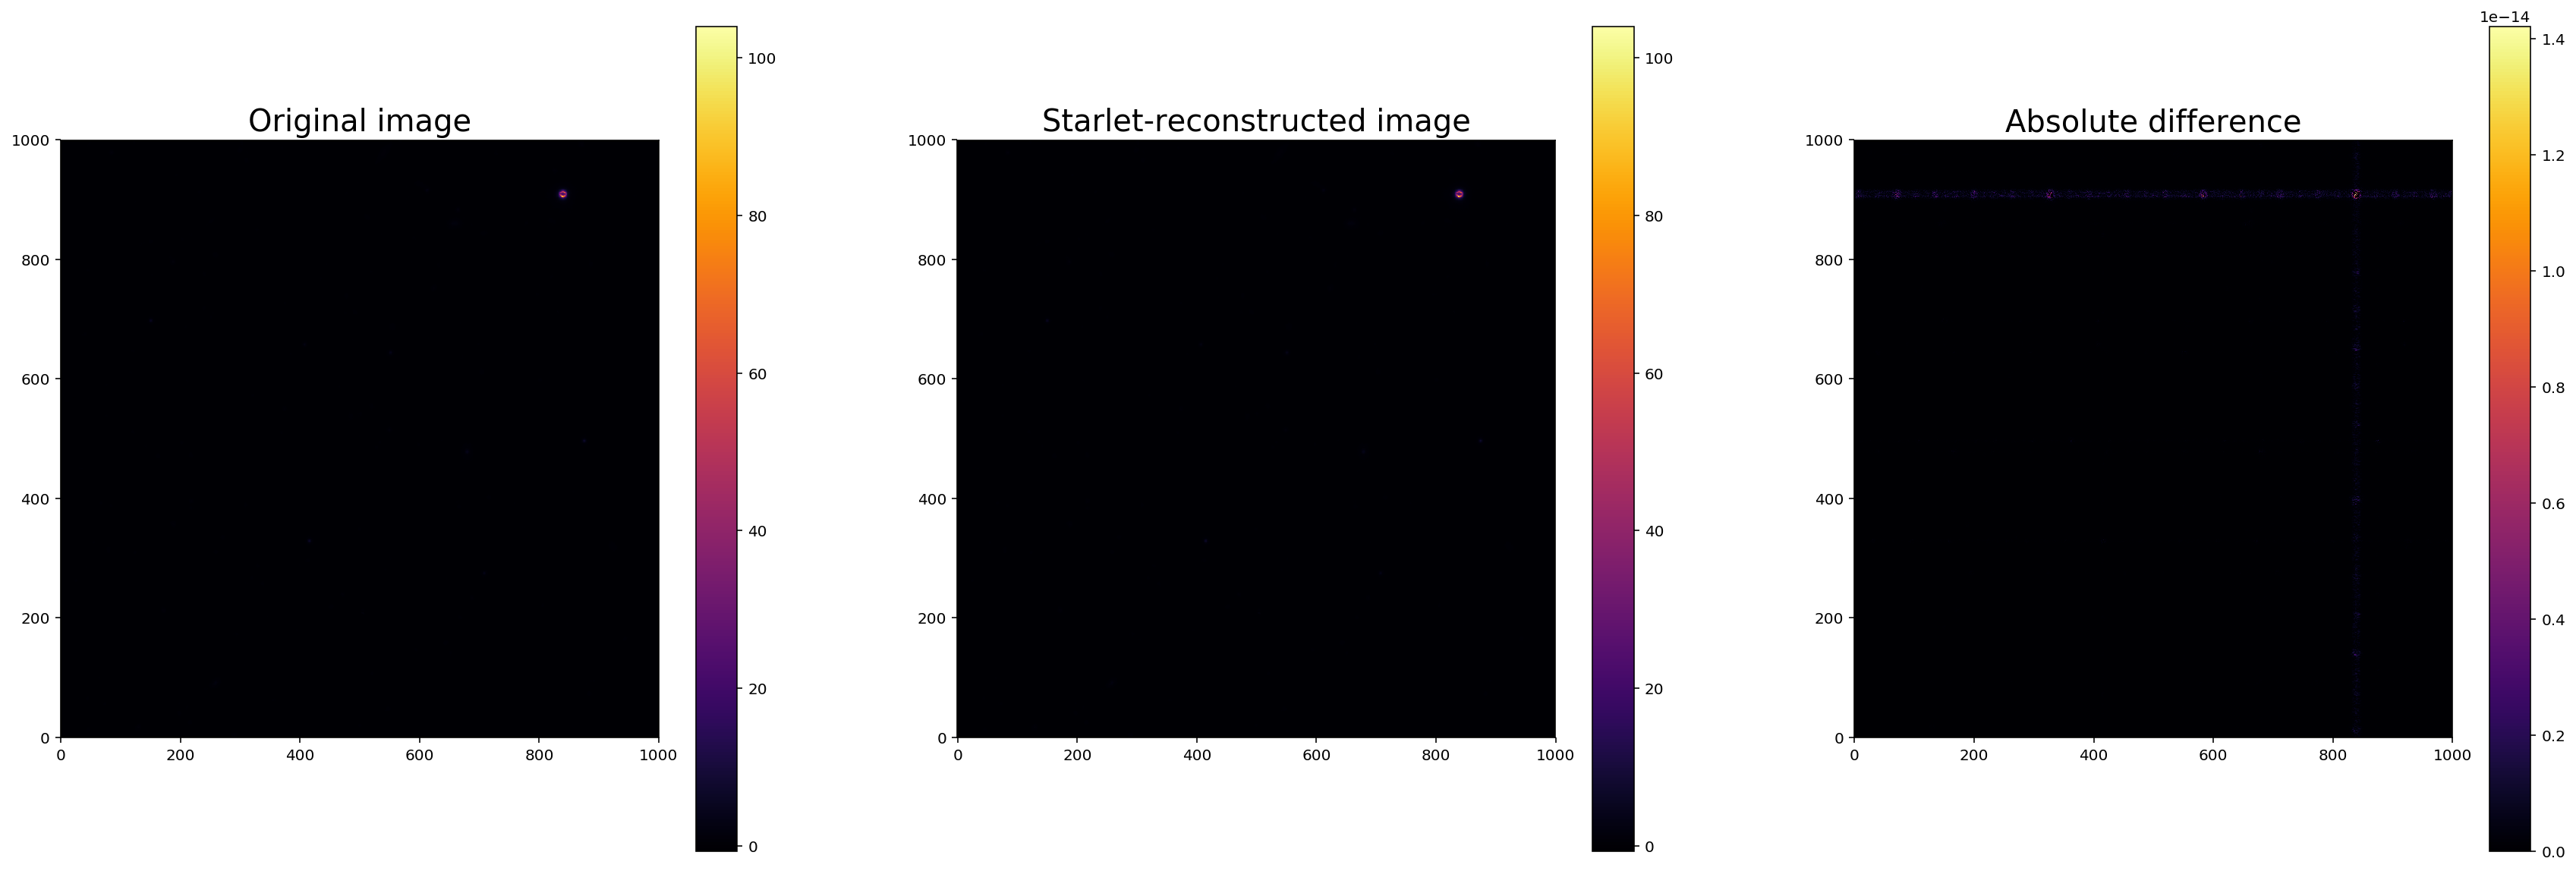

In [34]:
#Declare a starlet object (and performs the transform)
Sw = scarlet.Starlet(images, lvl = 4, direct = True)
#This is the starlet transform as an array
w = Sw.coefficients
#The inverse starlet transform of w (new object otherwise, the tranform is not used)
iw = Sw.image

#The wavelet transform of the first slice of images in pictures:
lvl = w.shape[1]
plt.figure(figsize = (lvl*5+5,5))
plt.suptitle('Wavelet coefficients')
for i in range(lvl):
    plt.subplot(1,lvl,i+1)
    plt.title('scale'+str(i+1))
    plt.imshow(w[0,i], cmap='inferno')
    plt.colorbar()
plt.show()

#Making sure we recover the original image:
plt.figure(figsize = (30,10))
plt.subplot(131)
plt.title('Original image', fontsize = 20)
plt.imshow(images[0], cmap='inferno')
plt.colorbar()
plt.subplot(132)
plt.title('Starlet-reconstructed image', fontsize = 20)
plt.imshow(iw[0], cmap='inferno')
plt.colorbar()
plt.subplot(133)
plt.title('Absolute difference', fontsize = 20)
plt.imshow((np.abs(iw[0]-images[0])), cmap='inferno')
plt.colorbar()
plt.show()

## Define Model Frame and Observation

A `Frame` in *scarlet* is a description of the hyperspectral cube of the model or the observations. Think of it as the metadata, what aspects of the sky are described here. At the least, a `Frame` holds the `shape` of the cube, for which we use the convention `(C, Ny, Nx)` for the number of elements in 3 dimensions: `C` for the number of bands/channels and `Ny, Nx` for the number of pixels at every channel.

An `Observation` combines a `Frame` with several data units, similar to header-data arrangement in FITS files. In addition to the actual science image cube, you can and often must provide weights for all elements in the data cube, an image cube of the PSF model (one image for all or one for each channel), an `astropy.WCS` structure to translate from pixel to sky coordinates, and labels for all channels. The reason for specifying them is to enable the code to internally map from the model frame, in which you seek to fit a model, to the observed data frame.

In [35]:
# Model

model_psf = scarlet.GaussianPSF(sigma = 0.8)

model_frame = scarlet.Frame(
    images.shape,
    psf=model_psf,
    channels=filters)

# HSC observation frame from data

#would be replaced by data psf it we had one :( )
#also make slightly different from model_psf
observation_psf = scarlet.GaussianPSF(sigma = 0.6) 

observation = scarlet.Observation(
    images,
    psf=observation_psf, 
    weights=weights,
    channels=filters).match(model_frame)

#### Let's investigate if our detection catalog makes sense. Look at detections:

In [38]:
catalog;

(1.63693257e-05, 46, 44, 563, 571, 994, 999, 567.23419216, 996.97104756, 3.48085286, 1.92792384, 0.05305925, 0.00096818, 0.00047996, 2.66198476e-05, 1.8661896, 1.3878448, 0.03411417, 0.28740647, 0.51891041, -0.01581968, 0.00274356, 0.00294679, 0.0001298, 0.00014824, 567, 997, 567, 998, 2)


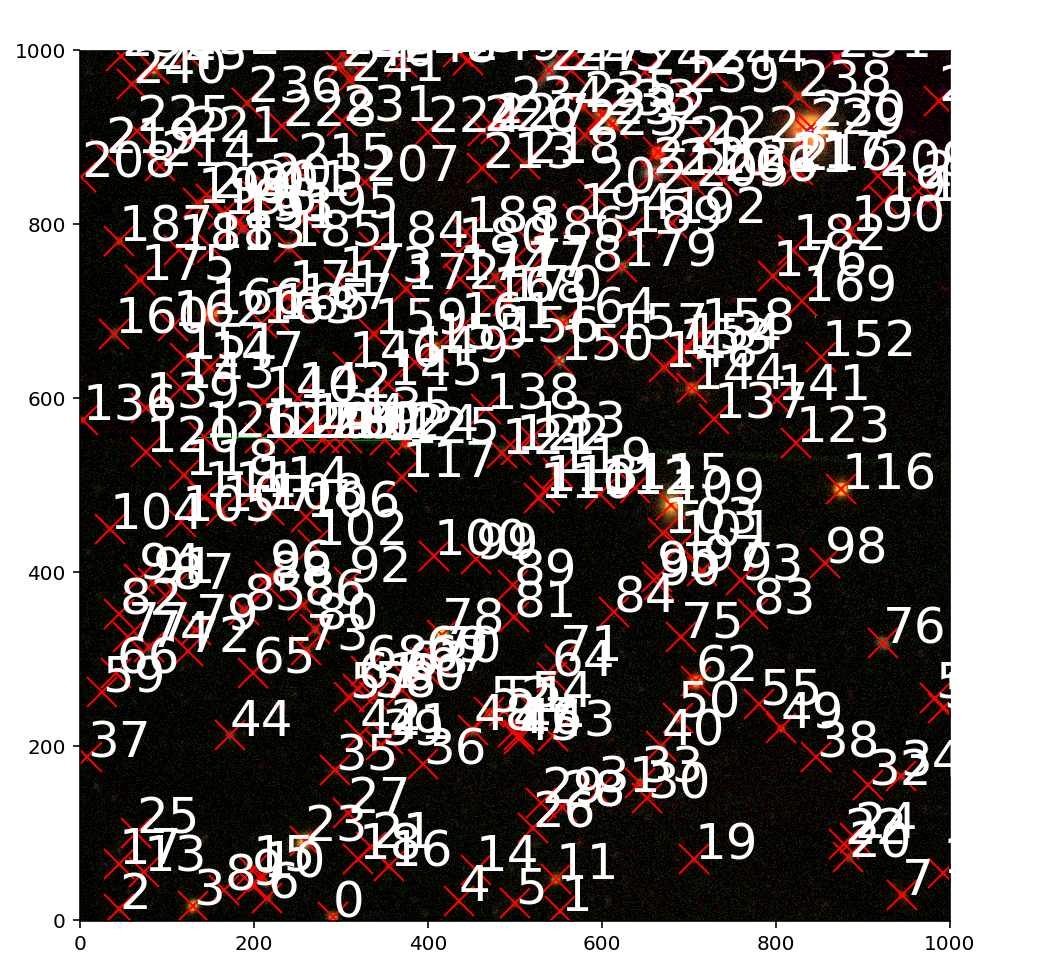

In [39]:
plt.figure(figsize = (8,8))
plt.imshow(img_rgb)

# Mark all of the sources from the detection cataog
for k, src in enumerate(catalog):
    plt.text(src["x"], src["y"], str(k), color="white", fontsize = 25)
    plt.plot(src["x"], src["y"], 'rx', markersize = 15)

print(src)

#### We can now make use of the convenience function `scarlet.display.show_observation` to plot observations as RGB images, with individual sources labeled at their position on the sky. It can also show the PSF in the same scaling.

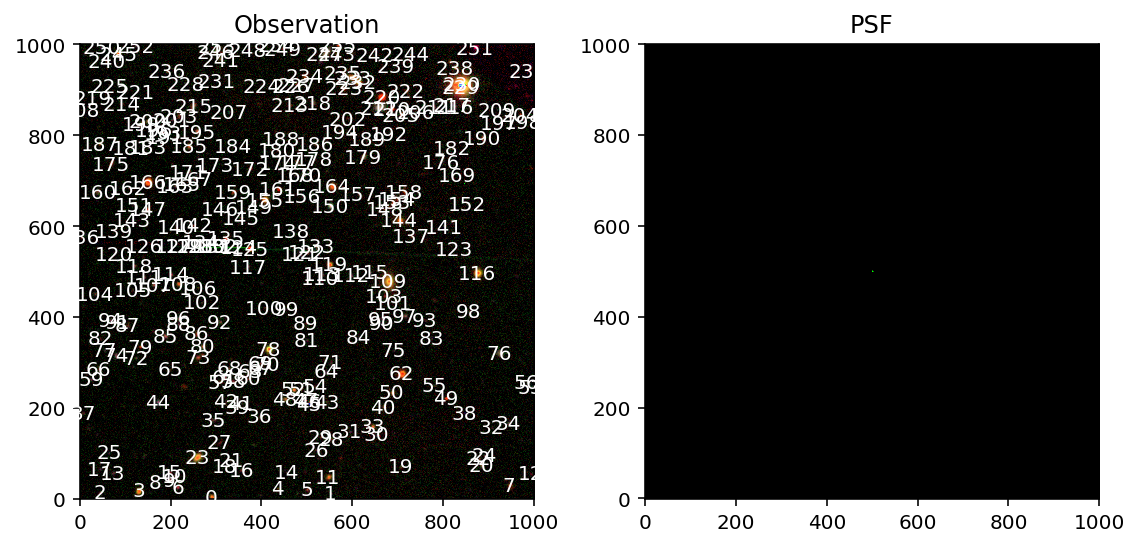

In [47]:
# Create a color mapping for the HSC image

# Get the source coordinates from the HST catalog
pixel_hsc = np.stack((catalog['y'], catalog['x']), axis=1)
# Convert the HST coordinates to the HSC WCS
ra_dec = observation.get_sky_coord(pixel_hsc)

scarlet.display.show_observation(observation, norm=norm, sky_coords=ra_dec, show_psf=True)
plt.show()

### Intialize sources

#### We now need to define sources that are going to be fit. The full model, which we will call Blend, is a collection of those sources. Also we choose to represent all components as ExtendedSources for simplicity, and we have no tidal sources where we model as 3+ `StarletSources`, so ignore that part:

In [49]:
%%time

starlet_sources = []
for k,src in enumerate(catalog):
    #if k in [12,13,16]:
    #    new_source = scarlet.StarletSource(model_frame,
    #                    (src["x"], src["y"]), observation,
    #                    starlet_thresh = 1)
    #    starlet_sources.append(new_source)
    #else:
    new_source = scarlet.ExtendedSource(model_frame,
                                    (src['y'], src['x']),
                                    observation,
                                    K=1,
                                    compact = 1)
    starlet_sources.append(new_source)


CPU times: user 2.29 s, sys: 0 ns, total: 2.29 s
Wall time: 2.29 s


**NOTE:** 

~/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/scarlet-1.0.1+gfde109a-py3.7-linux-ppc64le.egg/scarlet/initialization.py in get_pixel_spectrum(sky_coord, observations, correct_psf, models)
    104         if obs.psf is not None:
    105             # correct spectrum for PSF-induced change in peak pixel intensity
--> 106             psf_model = obs.psf.get_model()._data
    107             psf_peak = psf_model.max(axis=(1, 2))
    108             spectrum /= psf_peak

AttributeError: 'numpy.ndarray' object has no attribute '_data'

**Solution --> Delete ._data such that psf_model.max works (can’t work on memoryview obj) in initialization.py**

### Create and Fit Model

#### The Blend class represents the sources as a tree and has the machinery to fit all of the sources to the given images. In this example the code is set to run for a maximum of 200 iterations, but will end early if the likelihood and all of the constraints converge.

CPU times: user 1min 29s, sys: 1.47 s, total: 1min 30s
Wall time: 1min 30s
scarlet ran for 32 iterations to logL = -2839296.395087312


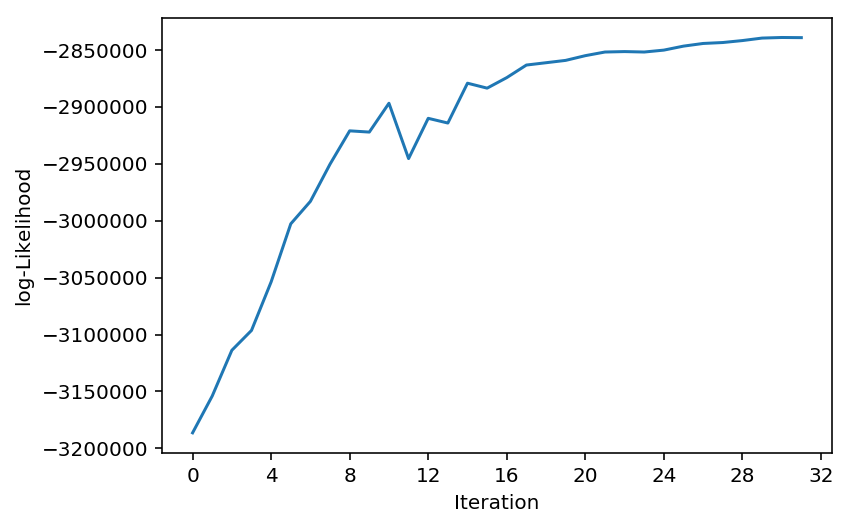

In [50]:
starlet_blend = scarlet.Blend(starlet_sources, observation)
%time it, logL = starlet_blend.fit(200, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(starlet_blend)
plt.show()

### View full scene

#### We will use scarlet.display.show_scene to render the entire scene. We then show model and data with the same 𝑠𝑖𝑛ℎ−1 stretch and the residuals with a linear stretch.

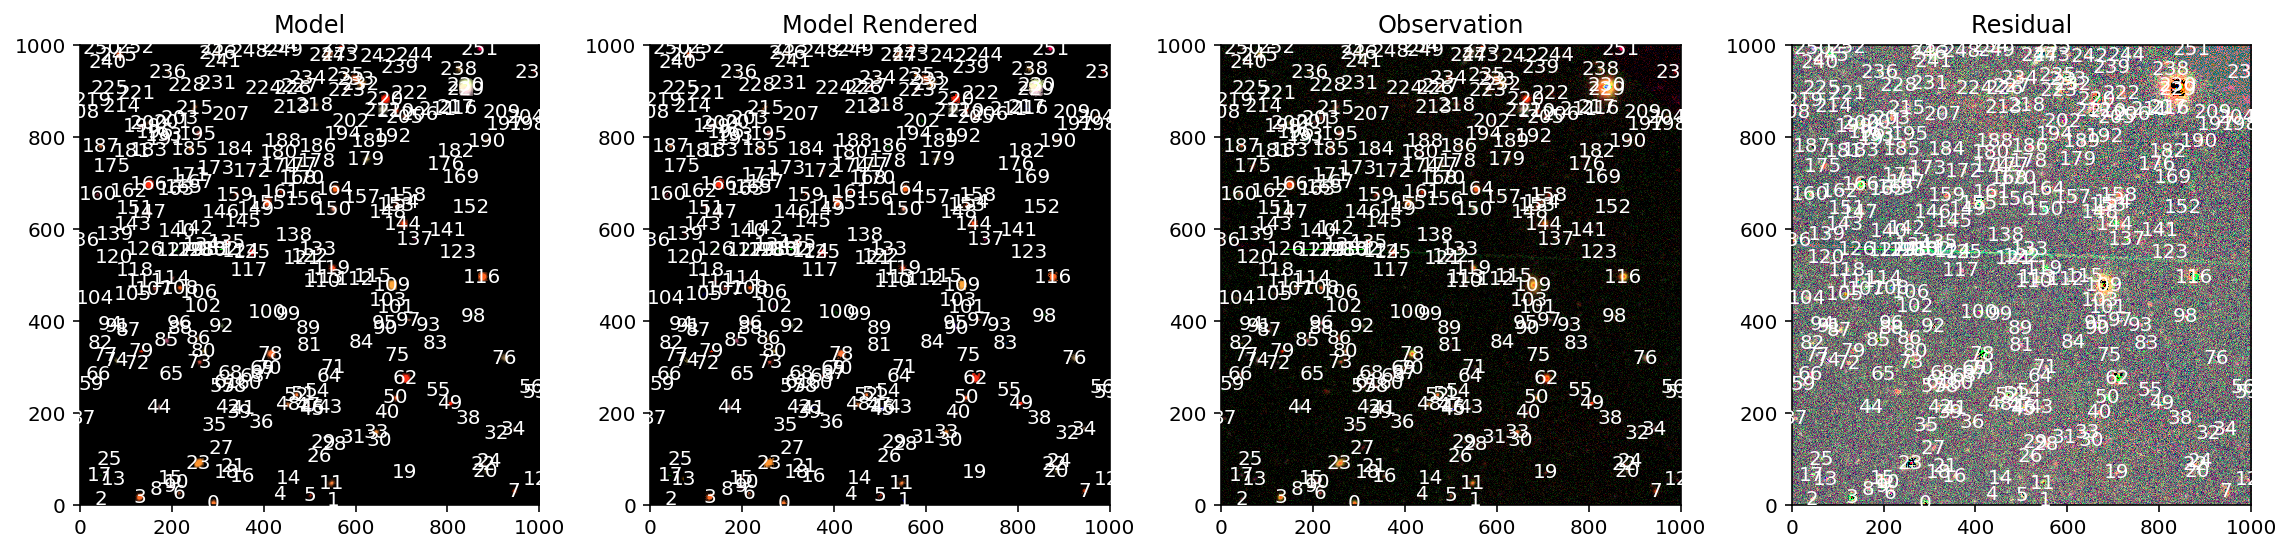

In [51]:
scarlet.display.show_scene(starlet_sources,
                           norm=norm,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True,
                          )
plt.show()

### View source models

#### We will now inspect the model for each source, in its original frame and in its observed frame by leveraging the show_sources method:

In [ ]:
scarlet.display.show_sources(starlet_sources,
                             norm=norm,
                             observation=observation,
                             #show_rendered=True,
                             #show_observed=True,
                             #add_boxes=True
                            )
plt.show()

### Subtracting and isolating the brightest starlet component

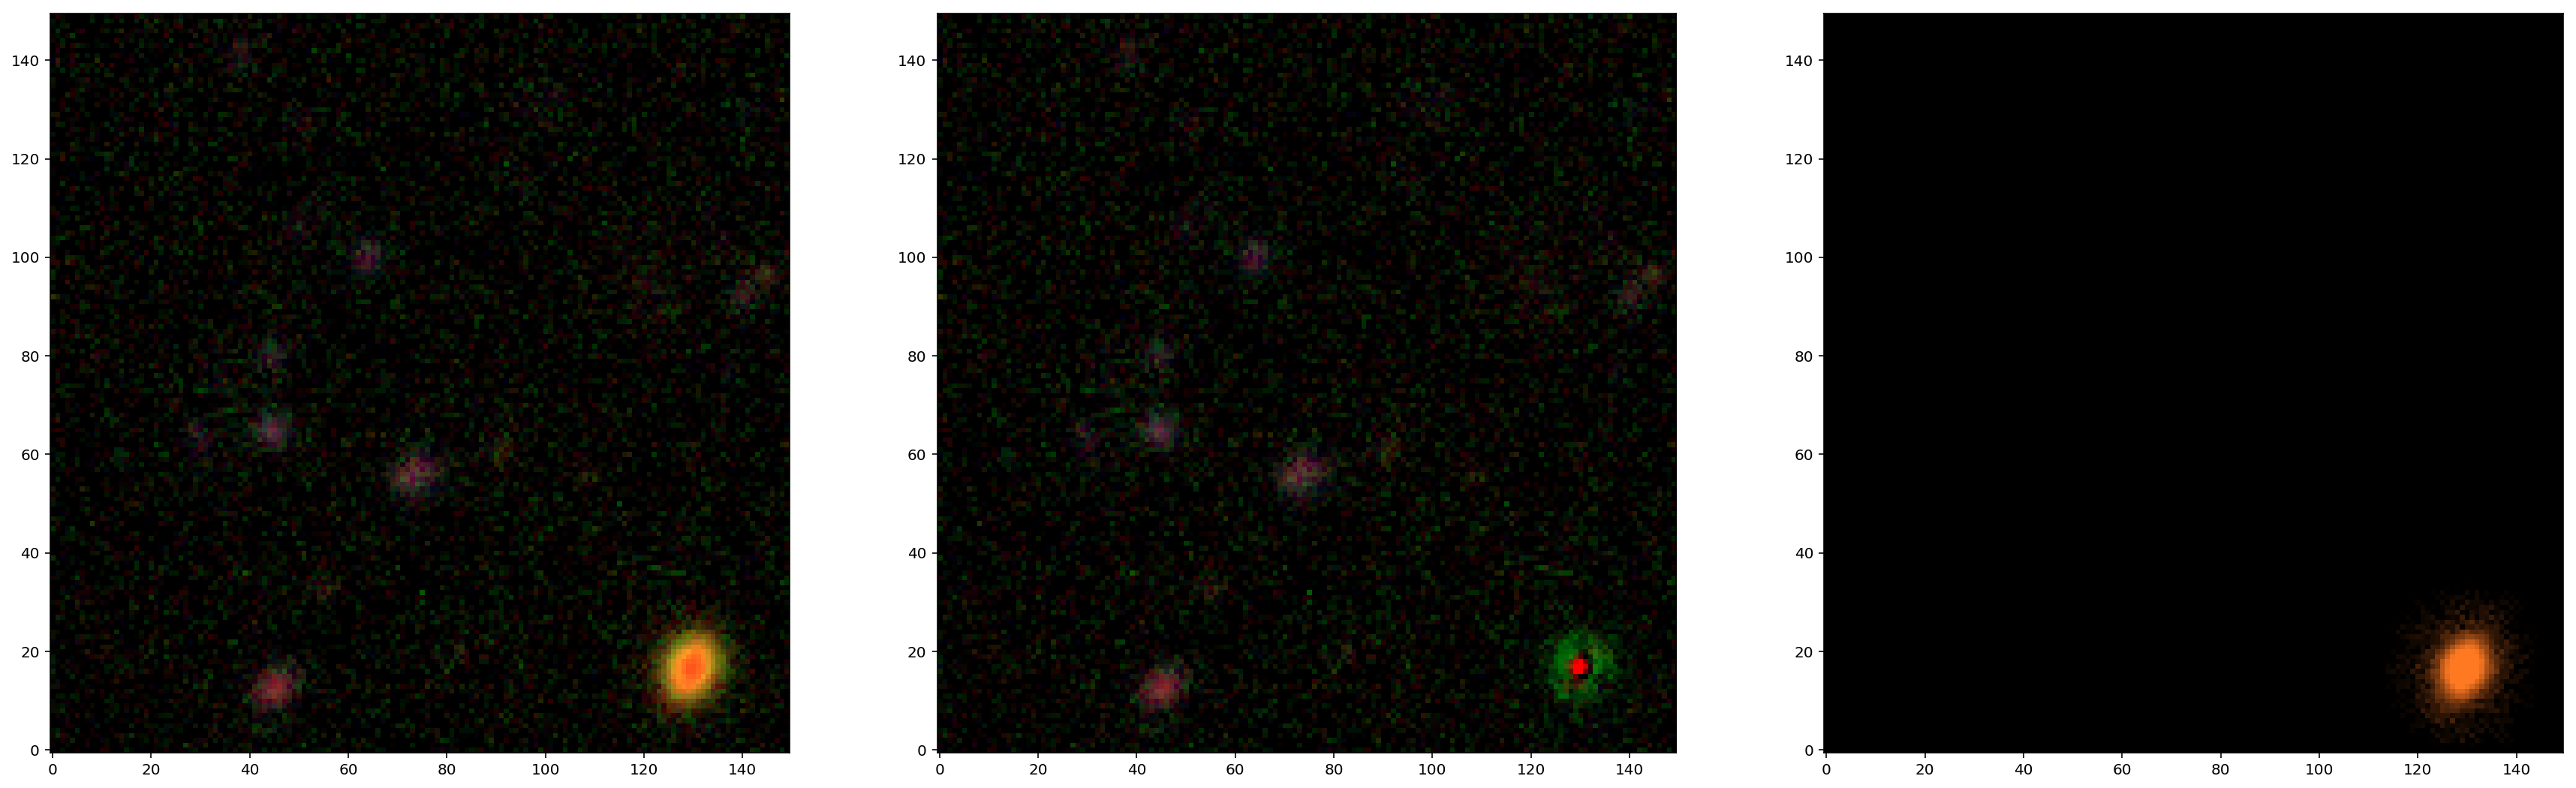

In [17]:
lsbg = starlet_sources[1].get_model(frame=model_frame)
model = 0
for k in range(len(starlet_sources)):
    model += starlet_sources[k].get_model(frame=model_frame)
lsbg = observation.render(lsbg)
res_rgb = scarlet.display.img_to_rgb(images-lsbg, norm=norm)
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
lsbg_rgb = scarlet.display.img_to_rgb(lsbg, norm=norm)
model_rgb = scarlet.display.img_to_rgb(images-model, norm=norm)

plt.figure(figsize = (30,15))
plt.subplot(131)
plt.imshow(img_rgb)

plt.subplot(133)
plt.imshow(lsbg_rgb)

plt.subplot(132)
plt.imshow(res_rgb)
plt.show()

:D 